In [0]:
# The code that is needed to load data at the platform Google Colaboratory

# !pip install pydrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# import re
# name = 'animals10.zip'
# url = "https://drive.google.com/open?id=1K1NpAMkupwNEaUACot6aPmN_vFgoCp4Y"

# id = re.search('id=(.*)', url)[1]

# downloaded = drive.CreateFile({'id': id})
# downloaded.GetContentFile(name)

# !rm adc.json

In [0]:
# !sudo apt install unzip
# !unzip animals10.zip -d "animals"
# !rm "animals10.zip"

In [0]:
# import all necessary libraries

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

import tensorflow as tf
from tqdm.notebook import tqdm

In [0]:
# The names of animals in this dataset are in Spanish, therefore, 
# for the correct display of the name of the animal, you must 
# have a dictionary that will translate them.

translate = {"cane": "dog", 
             "cavallo": "horse", 
             "elefante": "elephant", 
             "farfalla": "butterfly", 
             "gallina": "chicken", 
             "gatto": "cat", 
             "mucca": "cow", 
             "pecora": "sheep", 
             "scoiattolo": "squirrel", 
             "dog": "cane", 
             "cavallo": "horse", 
             "elephant" : "elefante", 
             "butterfly": "farfalla", 
             "chicken": "gallina", 
             "cat": "gatto", 
             "cow": "mucca", 
             "spider": "ragno", 
             "squirrel": "scoiattolo", 
             "ragno": "spider"}

In [5]:
# Create DataFrame that contains path to each image and contains the class to which that image belongs

folders = os.listdir('animals/raw-img')
categories = []
files = []

for k, folder in enumerate(folders):
    names = os.listdir("animals/raw-img/" + folder);
    for file in names:
        files.append("animals/raw-img/" + folder + "/" + file)
        categories.append(k)
        
full_data = pd.DataFrame({
    'path': files,
    'category': categories
})
sample = pd.DataFrame(columns=['path', 'category'])
for i in range(10):
    sample = sample.append(full_data[full_data['category'] == i].iloc[:800,:])

sample.reset_index(drop=True, inplace=True)
sample

,path,category
0,animals/raw-img/mucca/OIP-vq0SlJWU3hJzKZ7wYOr1...,0
1,animals/raw-img/mucca/OIP-l_o5BaDwY6OY5ejYPJcn...,0
2,animals/raw-img/mucca/OIP-MjQ9NMgvhID6g_WceAsH...,0
3,animals/raw-img/mucca/OIP-JPu-BXmsBMeYZR5HdDSd...,0
4,animals/raw-img/mucca/OIP-4X2EJtQpmbB--0n9VKxh...,0
...,...,...
7995,animals/raw-img/gatto/josh-couch-475167-unspla...,9
7996,animals/raw-img/gatto/656.jpeg,9
7997,animals/raw-img/gatto/498.jpeg,9
7998,animals/raw-img/gatto/1686.jpeg,9


In [0]:
# Assign path to the image to variable x and category to variable y.

x = sample['path']
y = sample['category']

x, y = shuffle(x, y, random_state=42)  # Shuffle

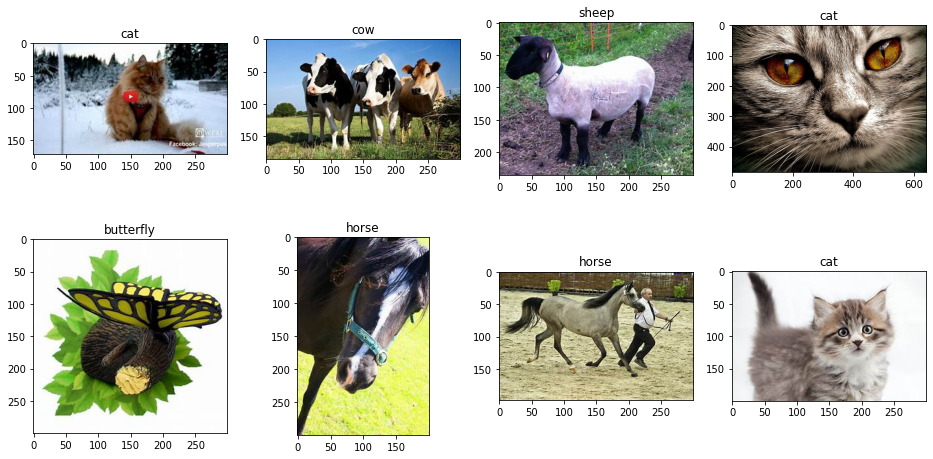

In [7]:
# Show some random images using matplotlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 2
for i in range(1, columns * rows + 1):
    num_of_image = random.randint(0, len(sample) - 1)
    img = mpimg.imread(sample.loc[num_of_image, 'path'])
    fig.add_subplot(rows, columns, i)
    plt.title(translate[sample.loc[num_of_image, 'path'].split('/')[2]])
    plt.imshow(img)

In [18]:
# setting image at the center 
def centering_image(img):
    size = [256,256]
    img_size = img.shape[:2]
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img
    return resized

# changing the width and the height of the image
images = []
with tqdm(total=len(sample)) as pbar:
    for i, file_path in enumerate(sample['path'].values):

        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        img = centering_image(cv2.resize(img, dsize=tile_size))
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

In [9]:
# division into train and test sample

data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

# setting range of value of each pixel from 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# creating list of categories
img_rows, img_cols, img_channel = 224, 224, 3
animals = []
for i in range(10):
    animal = sample.loc[sample['category'] == i, 'path'].iloc[0].split('/')[2]
    animals.append(translate[animal])

x_train (6400, 224, 224, 3)
y_train (6400,)
x_test (1600, 224, 224, 3)
y_test (1600,)


In [10]:
# creating convolutional neural network which is based on ResNet50V2

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = tf.keras.Sequential()
add_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(tf.keras.layers.Dense(256, activation='relu'))
add_model.add(tf.keras.layers.Dense(10, activation='softmax'))

model = tf.keras.Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
batch_size = 32
epochs = 50

# image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.1,
        horizontal_flip=True,
        rotation_range=30, 
        height_shift_range=0.1) 
train_datagen.fit(x_train)

# training model
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.ModelCheckpoint('ResNet50V2.h5', monitor='val_acc')]
)

Epoch 1/50
200/200 [==============================] - 101s 507ms/step - loss: 0.2265 - accuracy: 0.5230 - val_loss: 0.0910 - val_accuracy: 0.8238
Epoch 2/50
200/200 [==============================] - 100s 499ms/step - loss: 0.1131 - accuracy: 0.7730 - val_loss: 0.0680 - val_accuracy: 0.8712
Epoch 3/50
200/200 [==============================] - 100s 498ms/step - loss: 0.0899 - accuracy: 0.8258 - val_loss: 0.0588 - val_accuracy: 0.8906
Epoch 4/50
200/200 [==============================] - 100s 499ms/step - loss: 0.0734 - accuracy: 0.8572 - val_loss: 0.0532 - val_accuracy: 0.9056
Epoch 5/50
200/200 [==============================] - 100s 498ms/step - loss: 0.0663 - accuracy: 0.8708 - val_loss: 0.0503 - val_accuracy: 0.9056
Epoch 6/50
200/200 [==============================] - 101s 507ms/step - loss: 0.0610 - accuracy: 0.8825 - val_loss: 0.0478 - val_accuracy: 0.9175
Epoch 7/50
200/200 [==============================] - 101s 506ms/step - loss: 0.0573 - accuracy: 0.8923 - val_loss: 0.0457 -

CNN: Epochs=50, Train accuracy=0.97500, Validation accuracy=0.94250


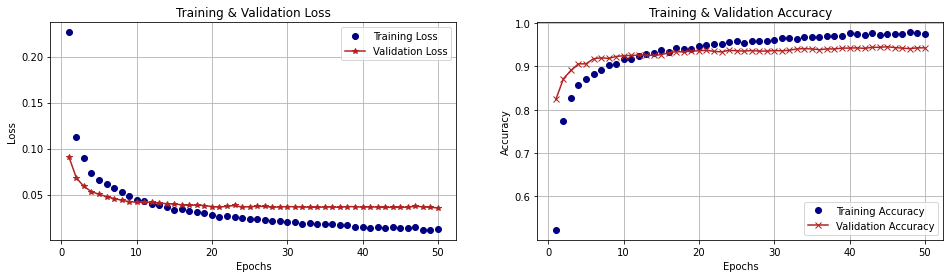

In [15]:
# show the history of training and validation score

print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    epochs = range(1, len(history['accuracy']) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    
    loss = history['loss']
    val_loss = history['val_loss']

    ax[0].plot(epochs, loss, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    ax[1].plot(epochs, accuracy, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_accuracy, color='firebrick', marker='x', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
  
    plt.show()
    plt.close()
    
show_plots(history.history)

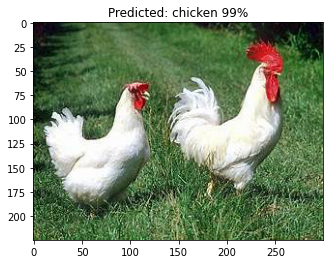

In [16]:
# testing model at random photo from the dataset
path = sample.loc[random.randint(0, len(sample) - 1), 'path']

img = mpimg.imread(path)
plt.imshow(img)    

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if(img.shape[0] > img.shape[1]):
    tile_size = (int(img.shape[1]*256/img.shape[0]),256)
else:
     tile_size = (256, int(img.shape[0]*256/img.shape[1]))

img = centering_image(cv2.resize(img, dsize=tile_size))
img = img[16:240, 16:240]
img = img[None, :, :, :]
img = img.astype('float32')
img /= 255

predicted = model.predict(img)
plt.title('Predicted: ' + animals[predicted.argmax()] + ' ' + str(int(predicted[0, predicted.argmax()] * 100)) + '%')
plt.show()